# Курсовой проект для курса "Python для Data Science"

### Материалы к проекту (файлы): train.csv test.csv

Задание: Используя данные из train.csv, построить модель для предсказания цен на недвижимость (квартиры). С помощью полученной модели предсказать цены для квартир из файла test.csv.

Целевая переменная: Price

Основная метрика: R2 - коэффициент детерминации 

Вспомогательная метрика: rmse -корень среднеквадратичного отклонения

Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"), разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

### Рекомендации для файла с кодом (ipynb):

1. Файл должен содержать заголовки и комментарии
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию, но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.
9. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.
10. Допускается применение библиотек Python и моделей машинного обучения, которые были в курсе Python для Data Science. Градиентный бустинг изучается в последующих курсах, поэтому в этом проекте его применять не следует. Самая сложная из допустимых моделей - RandomForestRegressor из sklearn.

### Построение модели регресси:

1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Подбор моделей, получение бейзлана
7. Проверка качества, борьба с переобучением
8. Интерпретация результатов

### Прогнозирование на тестовом датасете:

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Подключение библиотек и скриптов

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18, 10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

### Пути к директориям и файлам.

In [6]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

## Загрузка данных

### Описание датасета.

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [8]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [9]:
train_df.shape[1]-1 == test_df.shape[1]

True

## Приведение типов

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [11]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [12]:
train_df['Rooms'] = train_df['Rooms'].astype(int)
train_df['HouseFloor'] = train_df['HouseFloor'].astype(int)

In [13]:
train_df = train_df.drop('Id', axis =1 )

## Обзор данных

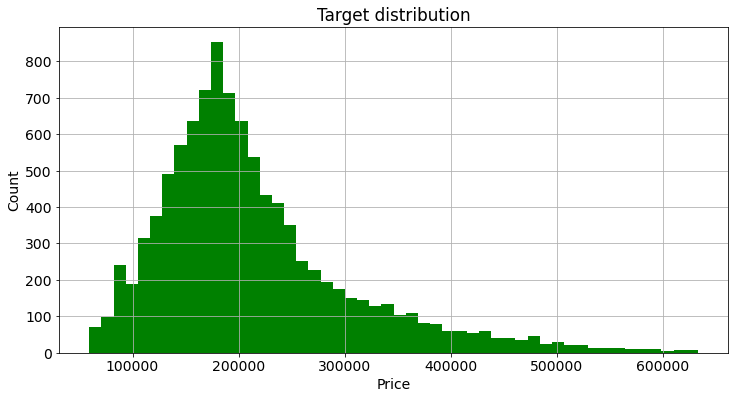

In [14]:
plt.figure(figsize=(12, 6))

train_df['Price'].hist(bins = 50, color='green')
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

### Количественные переменные.

In [15]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Качественные переменные.

In [16]:
train_df.select_dtypes(include='object').columns.tolist()

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [17]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

In [18]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [19]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [20]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

## Обработка выбросов

### Rooms.

In [21]:
class Preproc:
    def fit_emiss(self, data):
        self.emiss_median_rooms = data['Rooms'].median()
        self.emiss_median_LifeSquare = data['LifeSquare'].median()
        

    def transf_emiss(self, data):
        data.loc[(data['Rooms'] >= 6) | (data['Rooms'] == 0), 'Rooms'] = self.emiss_median_rooms
            

In [22]:
#prep = Preproc()
#prep.fit_emiss_rooms(train_df)
#prep.transf_emiss_rooms(train_df)
#prep.transf_emiss_rooms(test_df)

In [23]:
train_df['Rooms'].value_counts()

2     3880
1     3705
3     2235
4      150
5       18
0        8
10       2
19       1
6        1
Name: Rooms, dtype: int64

In [24]:
median = train_df['Rooms'].median()
train_df.loc[(train_df['Rooms'] >= 6) | (train_df['Rooms'] == 0), 'Rooms'] = median

In [25]:
test_df.loc[test_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = median

In [26]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.811056,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,5.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Square, LifeSquare, KitchenSquare.

In [27]:
train_df.shape

(10000, 19)

In [28]:
median_sq = train_df['Square'].median()
train_df.loc[(train_df['Square'] >= 300) | (train_df['Square'] < 9), 'Square'] = median_sq


In [29]:
test_df.loc[(test_df['Square'] >= 300) | (test_df['Square'] < 9), 'Square'] = median_sq

In [30]:
median_lifesq = train_df['LifeSquare'].median()
train_df.loc[(train_df['LifeSquare'] >= train_df['Square']) | (train_df['LifeSquare'] < 6), 'LifeSquare'] = median_lifesq


In [31]:
test_df.loc[(test_df['LifeSquare'] >= test_df['Square']) | (test_df['LifeSquare'] < 6), 'LifeSquare'] = median_lifesq

In [32]:
kitsq = train_df['KitchenSquare'].mean()
train_df.loc[(train_df['KitchenSquare'] >= train_df['LifeSquare']) | (train_df['KitchenSquare'] == 0), 'KitchenSquare'] = kitsq

#train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [33]:
test_df.loc[(test_df['KitchenSquare'] >= test_df['LifeSquare']) | (test_df['KitchenSquare'] == 0), 'KitchenSquare'] = kitsq

In [34]:
train_df.shape

(10000, 19)

In [35]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,56.224584,35.120612,6.203087,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.811056,19.063483,14.806485,4.190706,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,13.784865,8.822988,1.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.794392,23.453224,4.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.273300,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.889736,42.775804,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,5.000000,275.645284,233.949309,112.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


### Floor, HouseFloor.

In [36]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [37]:
train_df['HouseFloor'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  36,  37,  38,  39,  40,  44,
        45,  47,  48,  99, 117])

In [38]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [39]:
floor_out = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index

In [40]:
train_df.loc[floor_out, 'Floor'] = train_df.loc[floor_out, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [41]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,56.224584,35.120612,6.203087,7.396600,12.95910,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.811056,19.063483,14.806485,4.190706,5.042941,6.44346,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,1.000000,13.784865,8.822988,1.000000,1.000000,1.00000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.794392,23.453224,4.000000,3.000000,9.00000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.273300,6.000000,13.00000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.889736,42.775804,9.000000,11.000000,17.00000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,5.000000,275.645284,233.949309,112.000000,42.000000,117.00000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


## Обработка пропусков

In [42]:
len(train_df) - train_df.count()

DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [43]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [44]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] = train_df['LifeSquare'].median()

In [45]:
len(train_df) - train_df.count()

DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [46]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,56.224584,34.626307,6.203087,7.396600,12.95910,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1026.358900,1.319500,4.231300,214138.857399
std,0.811056,19.063483,13.183920,4.190706,5.042941,6.44346,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,746.662828,1.493601,4.806341,92872.293865
min,1.000000,13.784865,8.822988,1.000000,1.000000,1.00000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.794392,27.665387,4.000000,3.000000,9.00000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,830.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.273300,6.000000,13.00000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.889736,37.732537,9.000000,11.000000,17.00000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,990.000000,2.000000,6.000000,249135.462171
max,5.000000,275.645284,233.949309,112.000000,42.000000,117.00000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


## Новые признаки

In [47]:
train_df

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,27,3,115.027311,32.781260,10.0,4,10,2014,0.075424,B,B,11,3097,0,900.0,0,0,B,305018.871089
1,22,1,39.832524,23.169223,8.0,7,8,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,1,3,78.342215,47.671972,10.0,2,17,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,1,1,40.409907,32.781260,1.0,10,22,1977,0.007122,B,B,1,264,0,900.0,0,1,B,168106.007630
4,94,2,64.285067,38.562517,9.0,16,16,1972,0.282798,B,B,33,8667,2,900.0,0,6,B,343995.102962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,61,2,49.090728,33.272626,6.0,3,12,1981,0.300323,B,B,52,10311,6,900.0,1,9,B,119367.455796
9996,27,2,64.307684,37.038420,9.0,13,13,1977,0.072158,B,B,2,629,1,900.0,0,0,A,199715.148807
9997,178,1,29.648057,16.555363,5.0,3,5,1958,0.460556,B,B,20,4386,14,900.0,1,5,B,165953.912580
9998,21,1,32.330292,22.326870,5.0,3,9,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855


### Разбиение на train / test

In [48]:
feat = ['Rooms', 'Square', 'LifeSquare', 'Floor']
x = train_df[feat]
y = train_df['Price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle=True, random_state = 42)

### Модель Gradient Boosting Regressor

### Модель на Train

In [49]:
def evaluate_preds(true_values, pred_values, save=False):
   
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Sample prediction')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.942


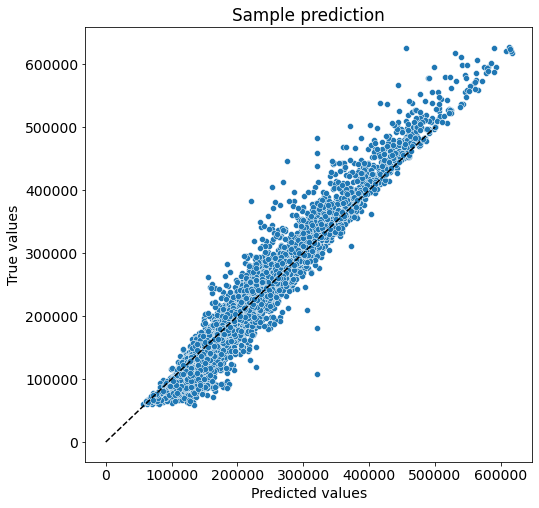

In [50]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=16,
                                     min_samples_leaf=4,
                                     random_state=42,  
                                     n_estimators=200)
gb_model.fit(x_train, y_train)

train_preds = gb_model.predict(x_train)
evaluate_preds(y_train, train_preds)

### Модель на Test

R2:	0.982


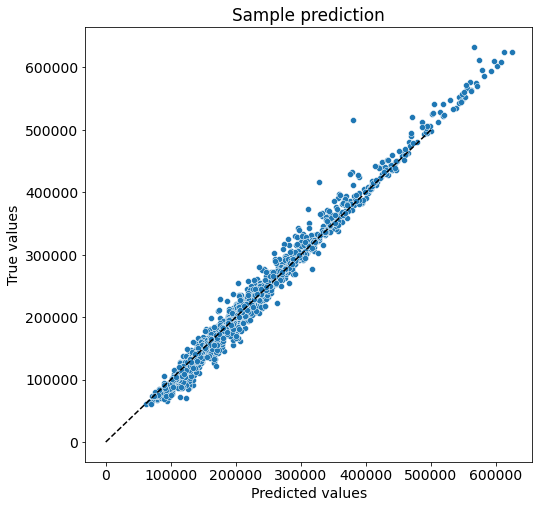

In [51]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=16,
                                     min_samples_leaf=4,
                                     random_state=42,  
                                     n_estimators=200)
gb_model.fit(x_test, y_test)

test_preds = gb_model.predict(x_test)
evaluate_preds(y_test, test_preds)

#### При построении модели Gradient Boosting Regressor было выявлено, что коэффициент детерминации R2 стремится к единице, признаков переобучения не выявлено. Поэтому эффективный прогноз будет построен на основании данной модели.

### Итоговое предсказание

In [52]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=16,
                                     min_samples_leaf=4,
                                     random_state=42,  
                                     n_estimators=200)
gb_model.fit(x, y)

GradientBoostingRegressor(criterion='mse', max_depth=16, min_samples_leaf=4,
                          n_estimators=200, random_state=42)

In [55]:
itog_test = test_df[feat]
itog_test = itog_test.fillna(1)
pred = pd.DataFrame(gb_model.predict(itog_test), columns=['Prise'])
pred

,Prise
0,179652.025994
1,131916.275737
2,275177.625371
3,210789.888945
4,265916.778781
...,...
4995,232458.997966
4996,466874.626552
4997,152745.098978
4998,177650.150857


In [56]:
pred.to_csv('Blinova_predict.csv')